# Part 1: Pulse Rate Algorithm

## Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


## Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

# Import

In [1]:
import glob
import os

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

from scipy.signal import savgol_filter

import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from pprint import pprint

In [2]:
# LOAD FUNCTIONS

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    if verbose:
        print("Troika dataset .mat filenames retrieved...")
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from Troika data.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
        
        ppg: Photoplethysmography (PPG) sensor signal
        accx: Accelerometer sensor signal along x-axis
        accy: Accelerometer sensor signal along y-axis
        accz: Accelerometer sensor signal along z-axis
    """
    data = sp.io.loadmat(data_fl)['sig']
        
    return data[2:]

def LoadReferenceDataFile(ref_fl):
    return sp.io.loadmat(ref_fl)['BPM0']

In [3]:
# EVALUATE FUNCTIONS

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    # are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]
    
    mae = np.mean(np.abs(best_estimates))
    
    if verbose:
        print("Computed error metric...")
        
    # Return the mean absolute error
    return mae

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Get data
    data_fls, ref_fls = LoadTroikaDataset()
    errors, confidences = [], []
    
    if verbose:
        print("Running PulseRateAlgorithm...")

    # Run PulseRateAlgorithm on each trial in the data
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        err, conf = RunPulseRateAlgorithm(data_fl, ref_fl, fs, multiplier)
        errors.append(err)
        confidences.append(conf)
        
    # Get aggregate error metric
    errors = np.concatenate(errors)
    confidences = np.concatenate(confidences)
    return AggregateErrorMetric(errors, confidences)

In [4]:
# DATA PROCESSING FUNCTIONS

def BandpassFilter(signal, fs):
    """
    Filters out low and high frequencies.

    Args:
        signal [np_array]: input signal
        fs [int]: Hz of input signal

    Returns:
        [np_array]: filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def FourierTransform(signal, fs, n):
    """
    Compute Fourier transform.

    Args:
        signal (np_array): input signal
        fs (int): Hz of input signal
        n: ppg length * multiplier for higher spectral resolution

    Returns:
        fft (np_array): 1-dimensional Fourier transform
        freqs (np_array): Fourier transformed frequencies
    """
    fft = np.abs(np.fft.rfft(signal, n))
    freqs = np.fft.rfftfreq(n, 1/fs)
    return fft, freqs

def AggregateAcc(accx, accy, accz, n):
    """
    Aggregate accelerometer data into single signal with L2Norm.
    
    Args:
        accx: Accelerometer sensor signal along x-axis
        accy: Accelerometer sensor signal along y-axis
        accz: Accelerometer sensor signal along z-axis
        n: ppg length * multiplier for higher spectral resolution
    
    Returns:
        aggregated accelerometer data into a single signal
    """ 
    acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_fft = np.abs(np.fft.rfft(acc_mag, n))  
    return acc_mag, acc_fft

def PreprocessData(ppg, accx, accy, accz, fs, multiplier):
    """
    Preprocess ppg and acc data.
    
    Args:         
        ppg: Photoplethysmography (PPG) sensor signal
        accx: Accelerometer sensor signal along x-axis
        accy: Accelerometer sensor signal along y-axis
        accz: Accelerometer sensor signal along z-axis
    
    Returns: 
        fft: 1-dimensional Fourier transform smoothed with Savgol and Bandpass and filtered with BPM range specified
        freqs: ppg frequencies
        acc_fft: acc frequencies
    """
    # Filter signals between 40-240 BPM
    for s in [ppg, accx, accy, accz]:
        s = savgol_filter(s, 51, 3)
        s = BandpassFilter(s, fs)
    
    # Higher spectral resolution
    n = len(ppg) * multiplier
    
    fft, freqs = FourierTransform(ppg, fs, n)
    
    # Aggregate accelerometer data into single signal
    acc_mag, acc_fft = AggregateAcc(accx, accy, accz, n)
    
    # Filter signals with min and max BPM specified
    fft[freqs <= pass_band[0]] = 0.0
    fft[freqs >= pass_band[1]] = 0.0

    acc_fft[freqs <= pass_band[0]] = 0.0
    acc_fft[freqs >= pass_band[1]] = 0.0
    
    return fft, freqs, acc_fft

In [5]:
# UTILITY FUNCTIONS

def GetIndices(len_sig, len_ref):
    """
    Get indices based on given window length and window shift.
    
    Args:
        len_sig: length of given signal data
        len_ref: length of given reference data
    
    Returns:
        Start and end indices for iterating over set of signals in the algorithm.
    """
    if len_ref < len_sig:
        n = len_ref
    else:
        n = len_sig
    
    start_idx = (np.cumsum(np.ones(n) * window_shift) - window_shift).astype(int)
    end_idx = start_idx + window_length
    
    return start_idx, end_idx

def GetConfidence(freqs, fft_ft, bpm_max):
    """
    Computes confidence for a signal window.

    Args:
        freqs (np_array): list of frequenqies
        fft_ft (np_array): Fourier transformed signal
        bpm_max (float): max frequency

    Returns:
        Confidence
    """
    fundamental_freq_window = (freqs > bpm_max - minBPM/60) & (freqs < bpm_max + minBPM/60)
    return np.sum(fft_ft[fundamental_freq_window]) / np.sum(fft_ft)

In [6]:
# ML FUNCTIONS

def GetFeatures(ground_truth, ppg_fft, freqs, acc_fft):
    """
    Prepare features for ML model.
    
    Args: 
        ground_truth: reference data for ground truth (validation data)
        ppg_fft: fourier-transformed ppg data
        freqs: ppg frequencies
        acc_fft: acc frequencies
    
    Returns: 
        training and validation data for ML models
        
        X: the mean, std, amplification, and strongest signal for ppg and acc data as a feature numpy array
        y: ground_truth validation data
    """
    
    y = ground_truth
    
    mean_ppg = np.mean(ppg_fft)
    mean_acc = np.mean(acc_fft)
    
    std_ppg = np.std(ppg_fft)
    std_acc = np.std(acc_fft)
    
    amp_ppg = max(np.abs(ppg_fft))
    amp_acc = max(np.abs(acc_fft))
    
    arg_ppg = freqs[np.argmax(ppg_fft)]
    arg_acc = freqs[np.argmax(acc_fft)]
    
    X = np.array([mean_ppg,
                  mean_acc,
                  std_ppg,
                  std_acc,
                  amp_ppg,
                  amp_acc,
                  arg_ppg,
                  arg_acc])
    
    return X, y

In [7]:
# RANDOM FOREST REGRESSION FUNCTIONS

def TrainRegression(X, y):
    """
    Trains a Random Forest Regressor with KFold (splits=5).
    
    Args: 
        X: training data
        y: validation data
    
    Returns: 
        model: Random Forest Regression model
    """
      
    model = RandomForestRegressor(n_estimators=400,
                                  max_depth=20)
    kf = KFold(n_splits=5).split(X,y)

    for train_idx, test_idx in kf:
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
    
    return model

def PredictRegression(ppg, freqs, fft, X, y):
    """
    Computes BPM prediction and returns result alongside error and confidence.
    
    Args:
        ppg: Photoplethysmography (PPG) sensor signal
        freqs: Fourier transformed frequencies
        fft: 1-dimensional Fourier transform filtered with BPM range specified
        X: training data for regression
        y: validation data for regression
    
    Returns:
        numpy arrays for error, confidence and the bpm prediction
    """
    
    model = TrainRegression(X, y)

    error, confidence, bpm_pred = [], [], []
    for i, feature in enumerate(X):
        
        pred = model.predict(np.reshape(feature, (1, -1)))[0]
    
        pred_freq = pred / 55.0  # get estimated frequency
        conf = GetConfidence(freqs, fft, pred_freq)
        
        bpm_pred.append(pred)
        error.append(np.abs((pred - y[i])))
        confidence.append(conf)
        
    return np.array(error), np.array(confidence), np.array(bpm_pred)

In [8]:
def RunPulseRateAlgorithm(data_fl, ref_fl, fs, multiplier):
    """
    Runs the pulse rate prediction algorithm.
    - Loads data and reference
    - Predicts with specified model type
    
    Args:
        data_fl: (str) filepath to a troika .mat file.
        ref_fl: (str) filepath to a reference ground truth file.
    
    Returns:
        error and confidence retrieved from the algorithm
    
    """
    
    # Load data using LoadTroikaDataFile
    signals = LoadTroikaDataFile(data_fl)
    
    # Reference file
    ground_truth = LoadReferenceDataFile(ref_fl)

    # Compute pulse rate estimates and estimation confidence.
    start_idx, end_idx = GetIndices(signals.shape[1],
                                    len(ground_truth))
            
    X, y = [], []

    for i, start_i in enumerate(start_idx):
        end_i = end_idx[i]
        ref = ground_truth[i]

        ppg = signals[0, start_i:end_i]
        accx = signals[1, start_i:end_i]
        accy = signals[2, start_i:end_i]
        accz = signals[3, start_i:end_i]

        fft, freqs, acc_fft = PreprocessData(ppg,
                                             accx,
                                             accy,
                                             accz,
                                             fs,
                                             multiplier)

        X_i, y_i = GetFeatures(ref, fft, freqs, acc_fft)
        X.append(X_i)
        y.append(y_i)

    X = np.array(X)
    y = np.array(y)
    error, confidence, bpm_pred = PredictRegression(ppg,
                                                    freqs,
                                                    fft,
                                                    X,
                                                    y)

    if verbose:
        _, subject_id, run_type = data_fl.split('/')[-1].split('_')
        run_type = re.findall("\d+", run_type)[0]
        
        plt.figure(figsize=(16,6))
        plt.plot(bpm_pred, label='prediction')
        plt.plot(ground_truth, label='ground truth')
        plt.title(f'subject: {subject_id}, run type: {run_type}')
        plt.legend()
        plt.show()
        
    return error, confidence

In [9]:
verbose = True

---

# Load data

In [10]:
data_fls, ref_fls = LoadTroikaDataset()

Troika dataset .mat filenames retrieved...


In [11]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [12]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

---

# Parameters

In [13]:
fs = 125  # signals were sampled at 125 Hz
window_length = 8 * fs  # 8 second time window
window_shift = 2 * fs  # 2 second overlap to next window

minBPM, maxBPM = 40, 240
pass_band = (minBPM/60, maxBPM/60)

multiplier = 4

---

# EDA

In [14]:
def PlotAcc(ppg, accx, accy, accz):
    ts = np.arange(len(ppg)) / fs
    plt.figure(figsize=(16, 10))  
    plt.plot(ts, accx, label='x', alpha=0.5)
    plt.plot(ts, accy, label='y', alpha=0.5)
    plt.plot(ts, accz, label='z', alpha=0.5)
    plt.title(f'subject ID: {subject_id}, run type: {run_type}')
    plt.legend()
    plt.ylim((-4, 4))
    plt.show()

In [15]:
def PlotData(data, labels): 
    f, ax = plt.subplots(4, figsize=(16, 14))
    for i, a in enumerate(ax):
        ax[i].plot(data[i], label = labels[i])
        ax[i].set_title(labels[i])
        ax[i].legend()
    plt.show()

In [16]:
def PlotFilter(data, labels):
    for array, label in zip(data, labels):
        f, ax = plt.subplots(2, figsize=(16, 6))
        f.suptitle(label, fontsize=16, fontweight='extra bold')
        ax[0].plot(array, label = 'unfiltered', alpha=0.7)
        ax[0].plot(BandpassFilter(array, fs), label = 'filtered', alpha=0.7)
        ax[0].set_title('Bandpass')
        ax[0].legend()
        ax[1].plot(array, label = 'unfiltered', alpha=0.7)
        ax[1].plot(savgol_filter(array, 51, 3), label = 'filtered', alpha=0.7)
        ax[1].set_title('Savgol')
        ax[1].legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [17]:
def GetWindow(data, ground_truth):
    
    # Compute pulse rate estimates and estimation confidence.
    start_idx, end_idx = GetIndices(len(data), len(ground_truth))
    
    ppg_w = ppg[:fs*8]
    accx_w = accx[:fs*8]
    accy_w = accy[:fs*8]
    accz_w = accz[:fs*8]
    
    data_w = [ppg_w, accx_w, accy_w, accz_w]
    
    for s in data_w:
        s = BandpassFilter(s, fs)
        
    # Higher spectral resolution
    n = len(ppg_w) * multiplier

    # Aggregate accelerometer data into single signal
    acc_mag_w, acc_fft_w = AggregateAcc(accx_w, accy_w, accz_w, n)

    # Find peaks
    peaks_w = sp.signal.find_peaks(ppg_w, height = 10, distance=35)[0]
    
    return ppg_w, accx_w, accy_w, accz_w, acc_mag_w, peaks_w

In [18]:
def PlotWindow(ppg, peaks, acc_mag):    
    f, ax = plt.subplots(2, 1, figsize=(16,10))
    f.suptitle('Window Analysis', fontsize=16, fontweight='extra bold')
    ax[0].set_title('PPG with found peaks')
    ax[0].plot(ppg)
    ax[0].plot(peaks, ppg[peaks], "o")
    ax[1].set_title('Aggregated acc')
    ax[1].plot(acc_mag)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [19]:
def PlotFilterWindow(data, labels):
    for array, label in zip(data, labels):
        f, ax = plt.subplots(2, figsize=(16, 6))
        f.suptitle(label, fontsize=16, fontweight='extra bold')
        ax[0].plot(np.arange(fs*8) / fs, array[:fs*8], label = 'unfiltered')
        ax[0].plot(np.arange(fs*8) / fs, BandpassFilter(array, fs)[:fs*8], label = 'filtered')
        ax[0].set_title('Bandpass')
        ax[0].legend()
        ax[1].plot(np.arange(fs*8) / fs, array[:fs*8], label = 'unfiltered')
        ax[1].plot(np.arange(fs*8) / fs, savgol_filter(array, 51, 3)[:fs*8], label = 'filtered')
        ax[1].set_title('Savgol')
        ax[1].legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [20]:
def PlotSpectogram(ppg, title):
    plt.figure(figsize=(16,10))
    plt.title(f'Spectrogram {title}')
    spec, freqs, times, im = plt.specgram(ppg, Fs=fs, NFFT=fs*8, noverlap=fs*6, xextent=(0, len(ppg)/fs))
    plt.xlabel('time (sec)')
    plt.ylabel('frequency (Hz)')
    plt.show()
    print(f'freqs.shape: {freqs.shape}\ntimes.shape: {times.shape}')
    return spec, freqs, times, im

In [21]:
# PICK FILE TO ANALYZE
FILE = 1

In [22]:
data_fl, ref_fl = list(zip(data_fls, ref_fls))[FILE-1:FILE][0]
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ground_truth = LoadReferenceDataFile(ref_fl)

ppg.shape, ground_truth.shape

((37937,), (148, 1))

In [23]:
_, subject_id, run_type = data_fl.split('/')[-1].split('_')
run_type = re.findall("\d+", run_type)[0]

print(f"subject ID: \t{subject_id}\nrun type: \t{run_type}")

subject ID: 	01
run type: 	01


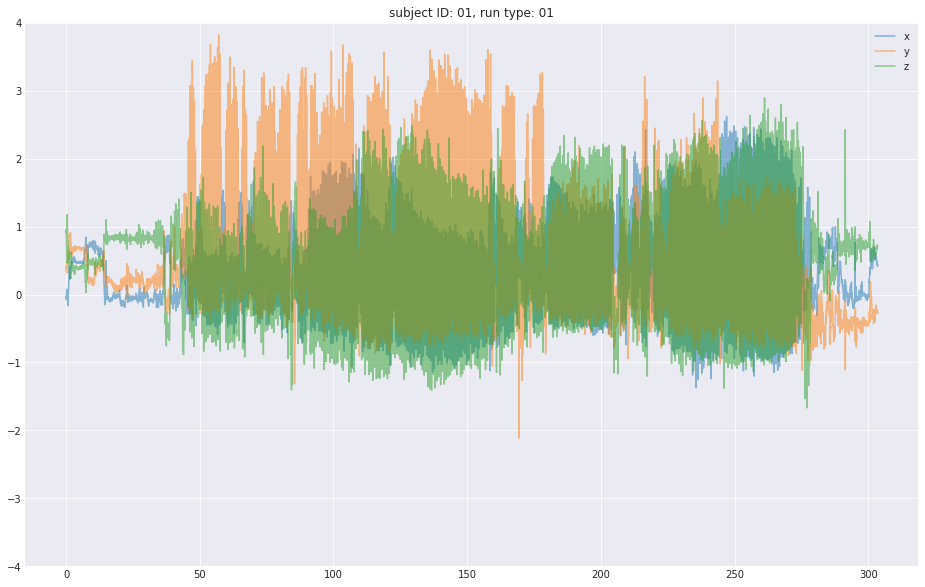

In [24]:
PlotAcc(ppg, accx, accy, accz)

In [25]:
data = [ppg, accx, accy, accz]
labels = ['ppg', 'accx', 'accy', 'accz']

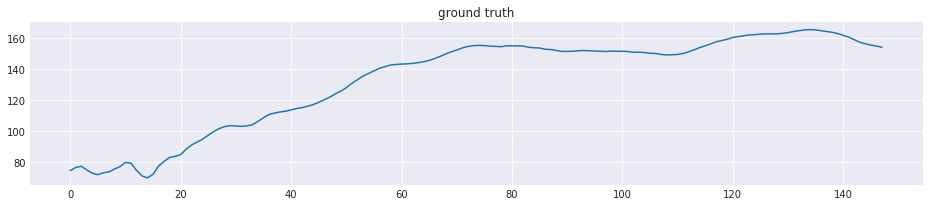

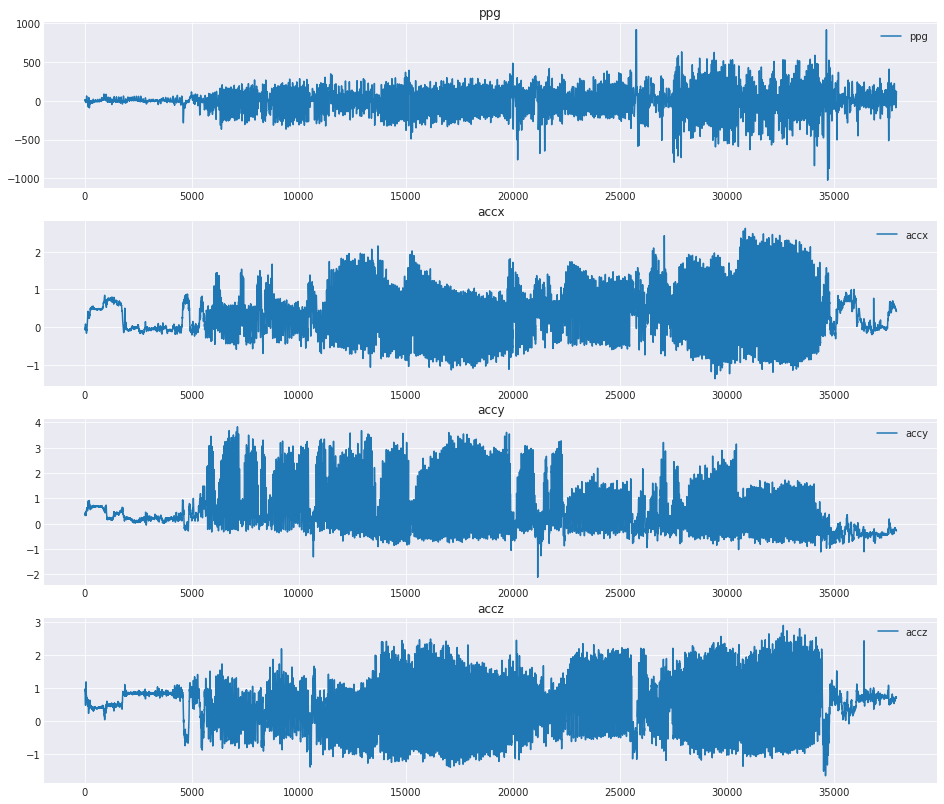

In [26]:
plt.figure(figsize=(16, 3))
plt.plot(ground_truth, label='ground truth')
plt.title('ground truth')
plt.show()

PlotData(data, labels)

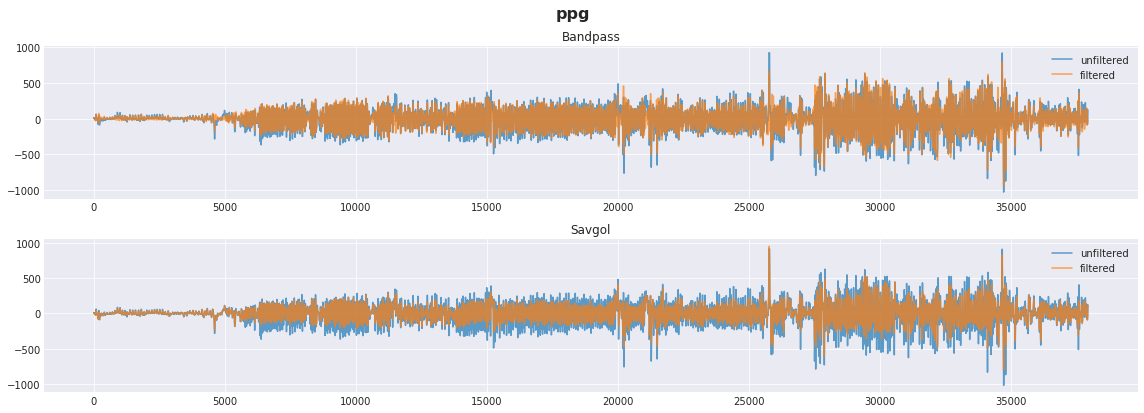

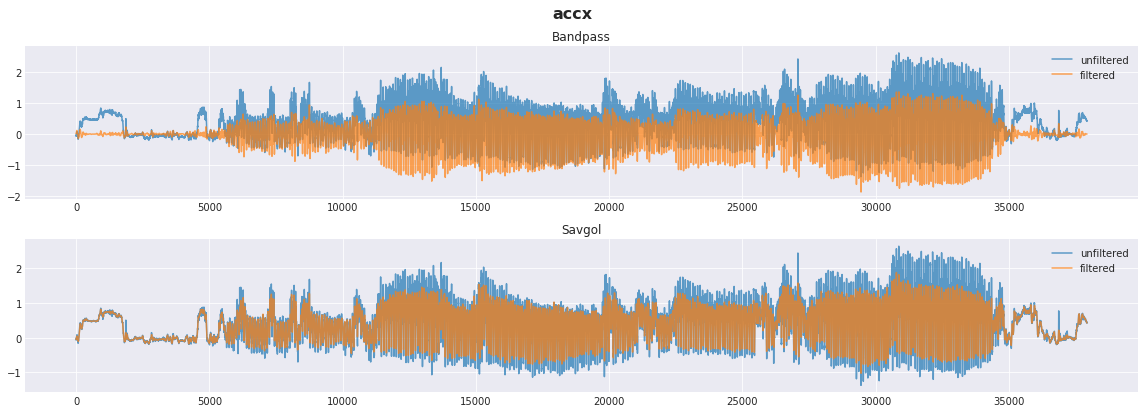

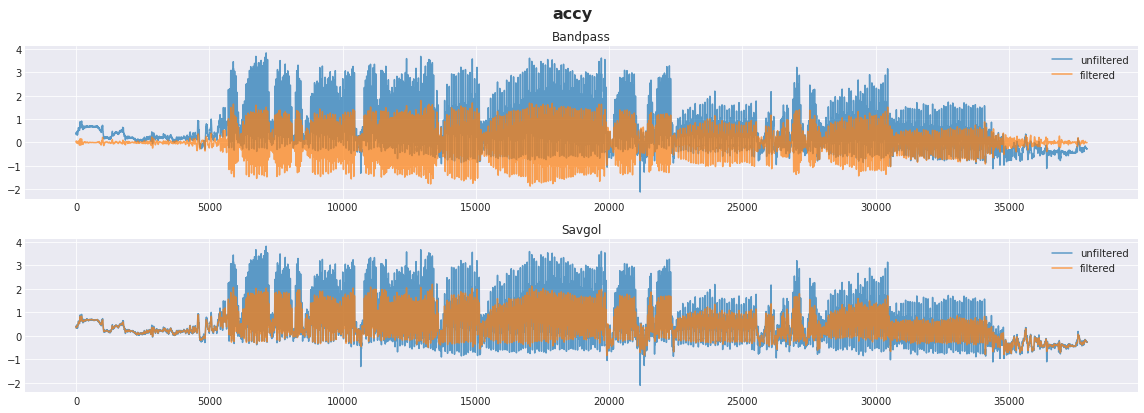

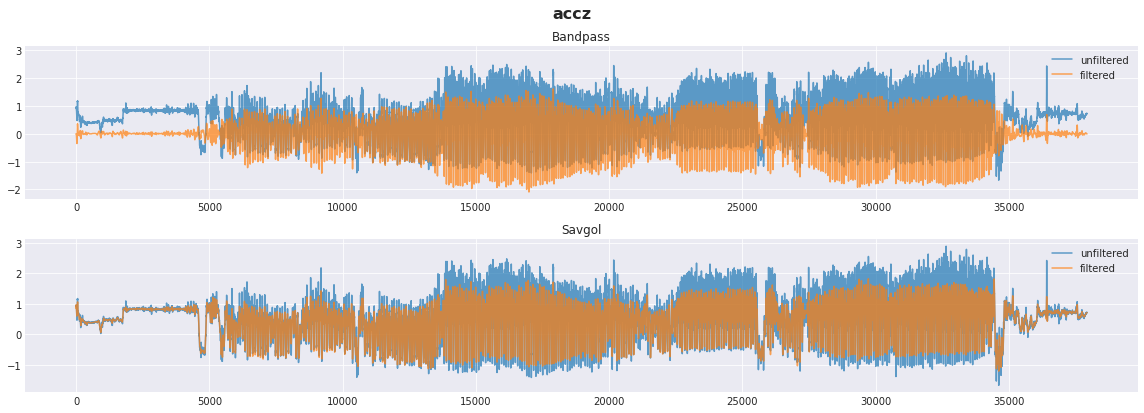

In [27]:
PlotFilter(data, labels)

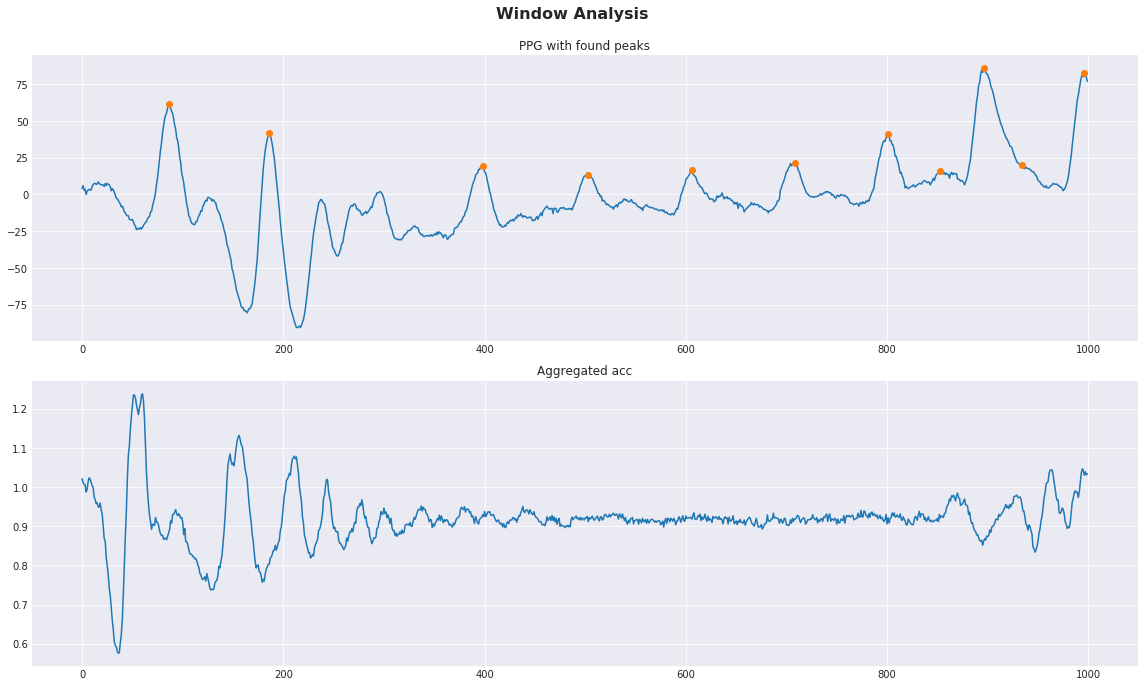

In [28]:
ppg_w, accx_w, accy_w, accz_w, acc_mag_w, peaks_w = GetWindow(data, ground_truth)
PlotWindow(ppg_w, peaks_w, acc_mag_w)

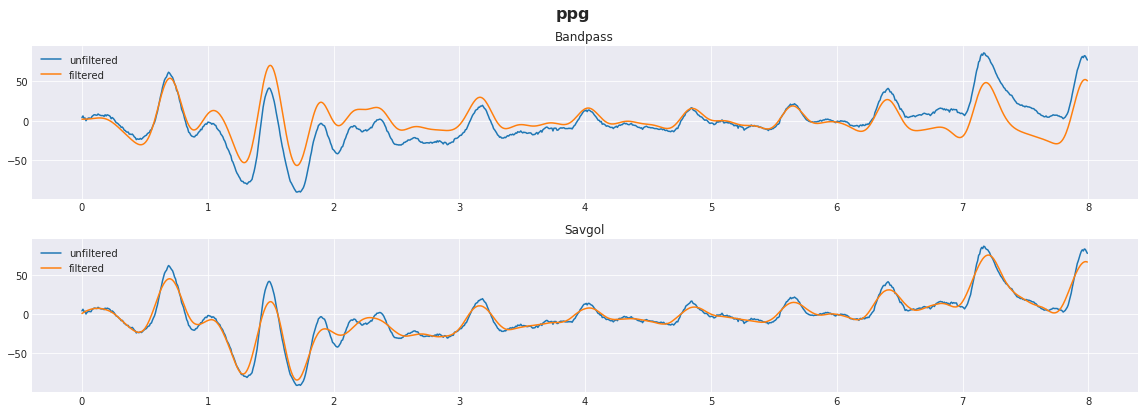

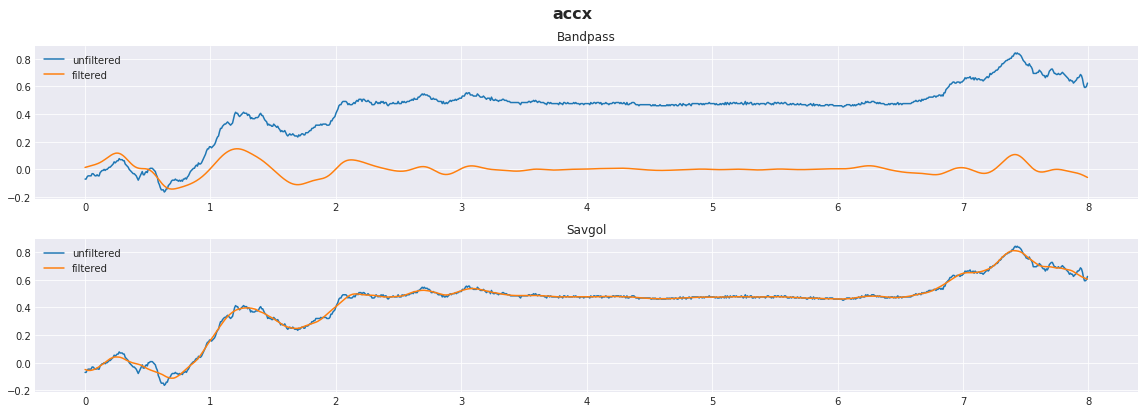

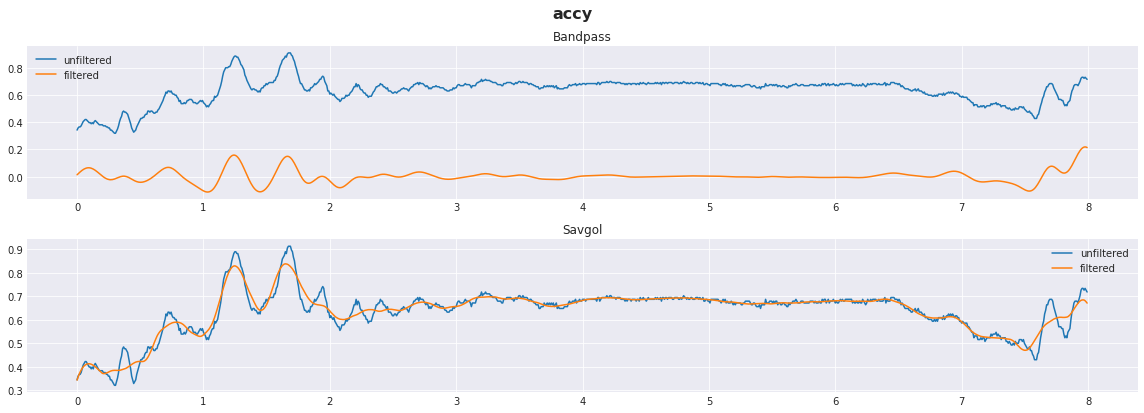

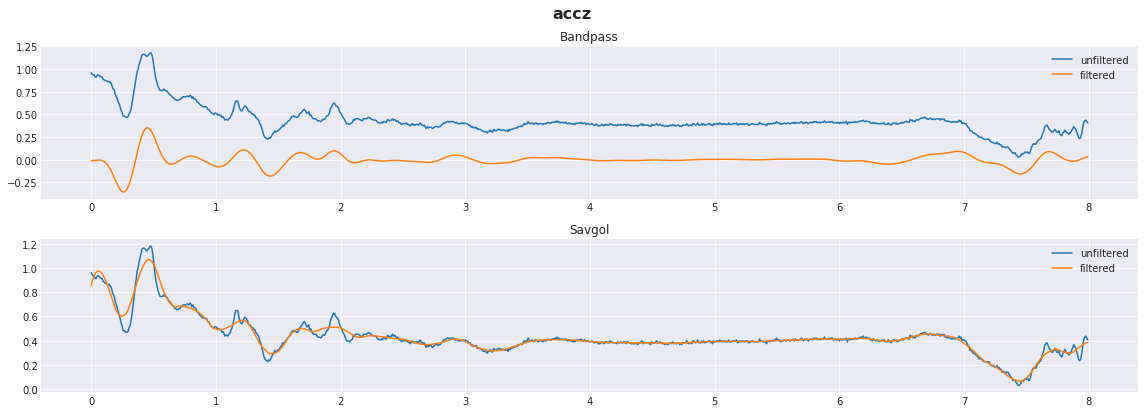

In [29]:
PlotFilterWindow(data, labels)

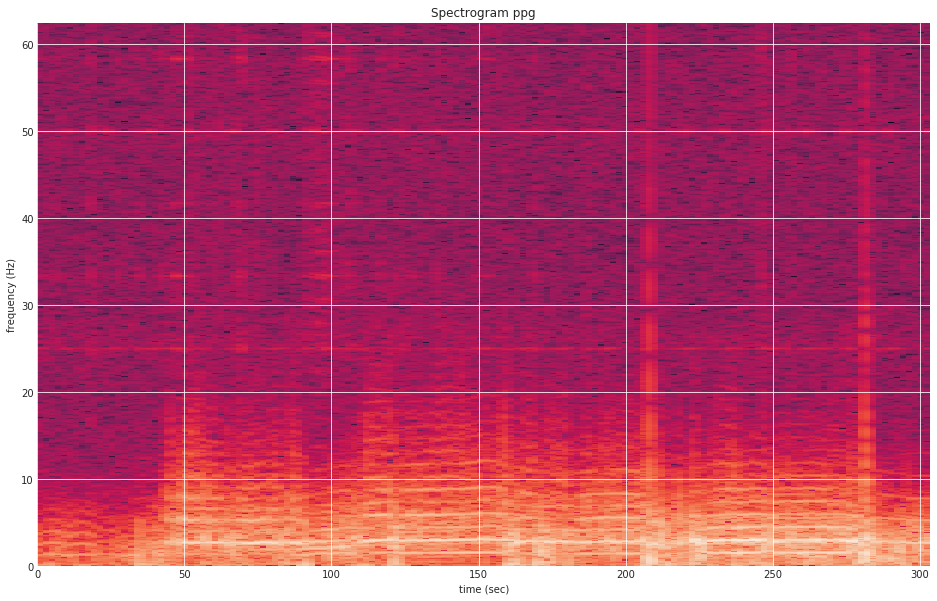

freqs.shape: (501,)
times.shape: (148,)


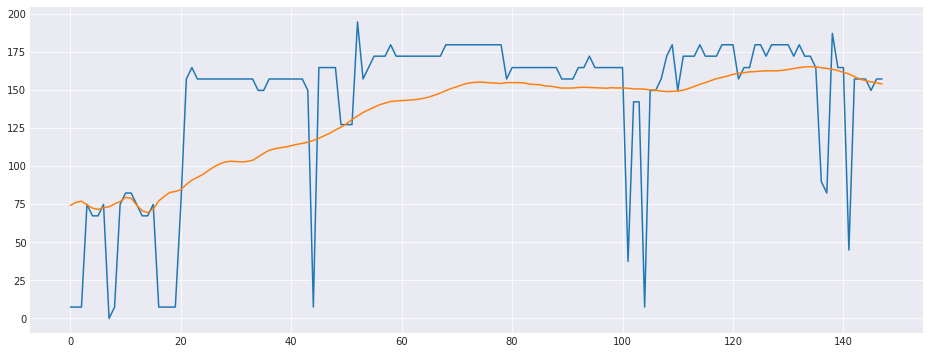

In [30]:
ppg_spec, ppg_freqs, _, _ = PlotSpectogram(ppg, 'ppg')

plt.figure(figsize=(16,6))
plt.plot(ppg_freqs[ppg_spec.argmax(axis=0)]*60)
plt.plot(ground_truth)
plt.show()

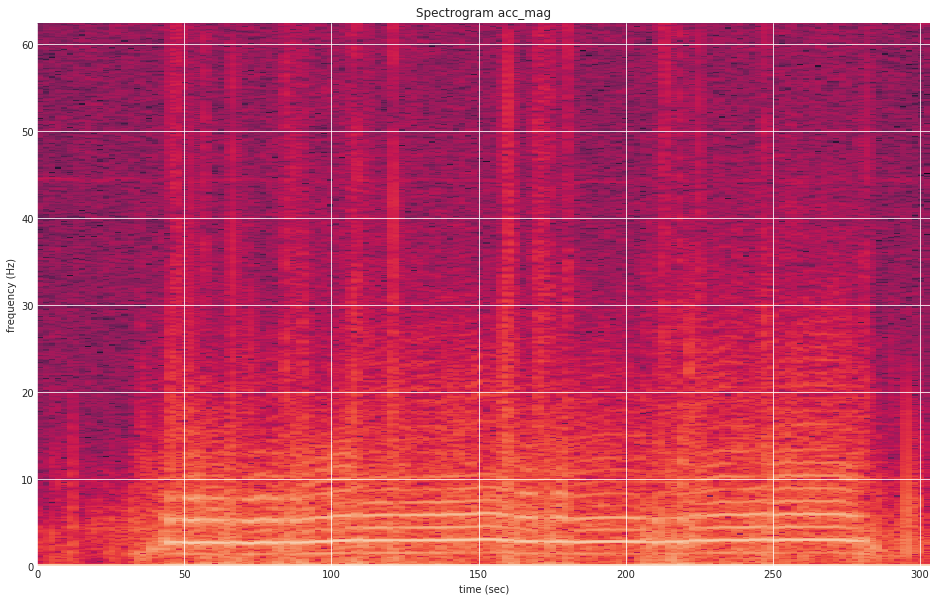

freqs.shape: (501,)
times.shape: (148,)


In [31]:
# Higher spectral resolution
n = len(ppg) * multiplier

# Aggregate accelerometer data into single signal
acc_mag, acc_fft = AggregateAcc(accx, accy, accz, n)

acc_spec, acc_freqs, _, _ = PlotSpectogram(acc_mag, 'acc_mag')

---

# Run algorithm

In [32]:
verbose = True

Troika dataset .mat filenames retrieved...
Running PulseRateAlgorithm...


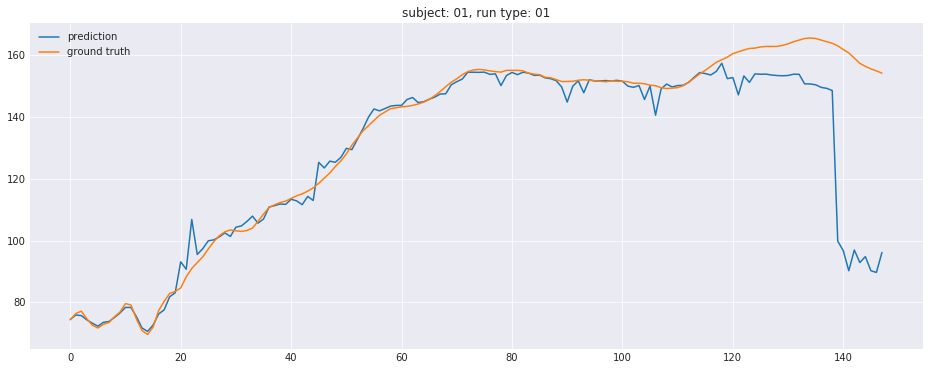

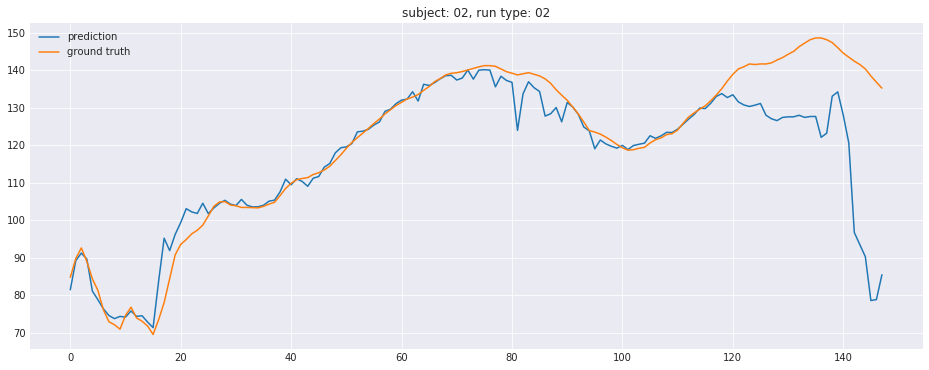

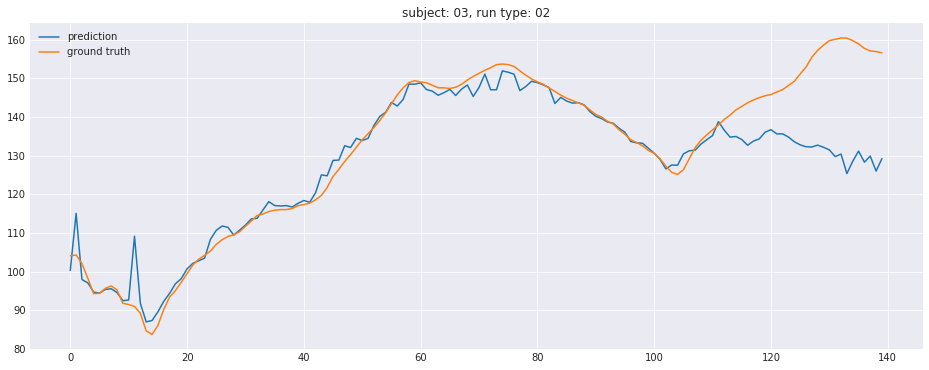

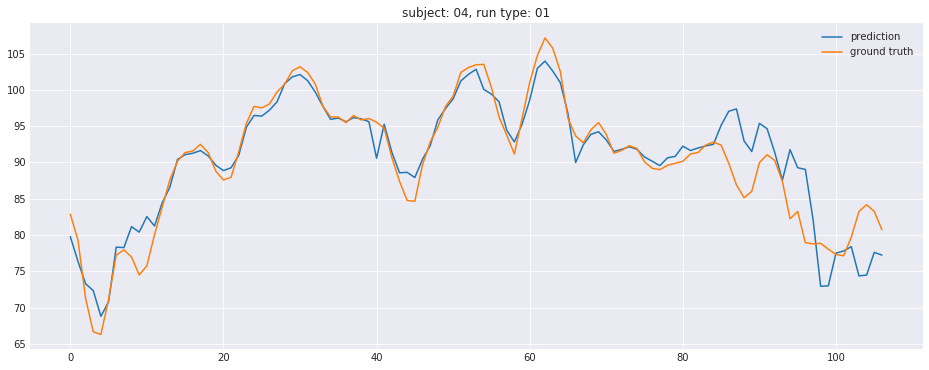

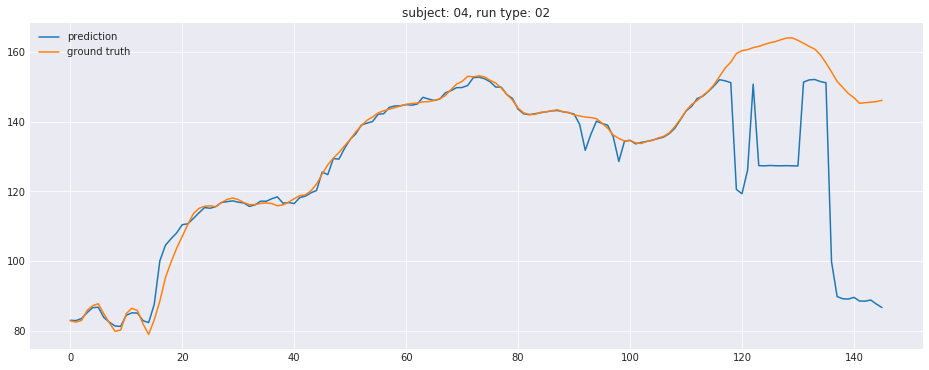

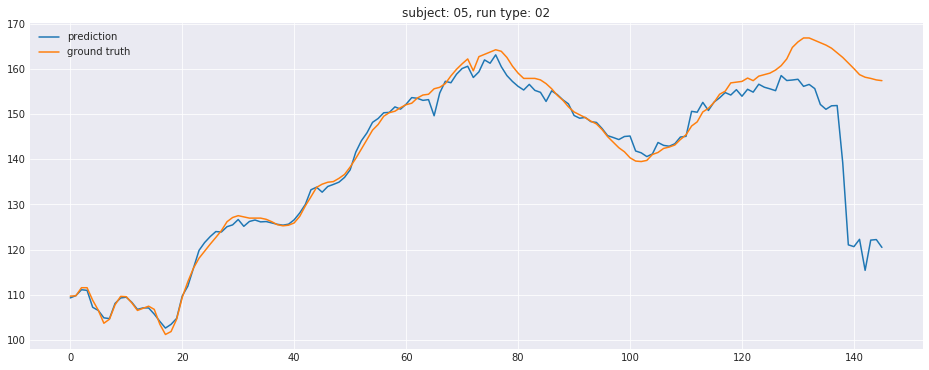

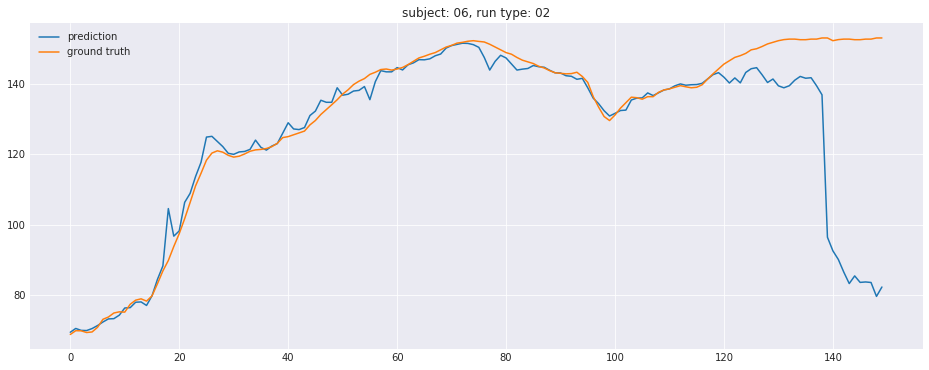

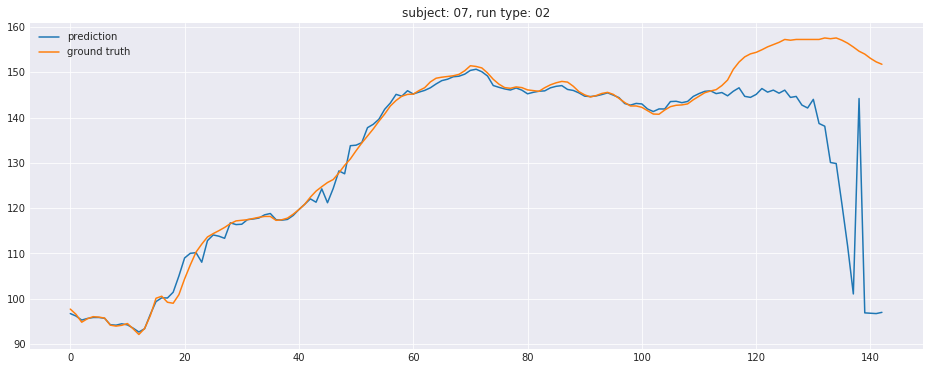

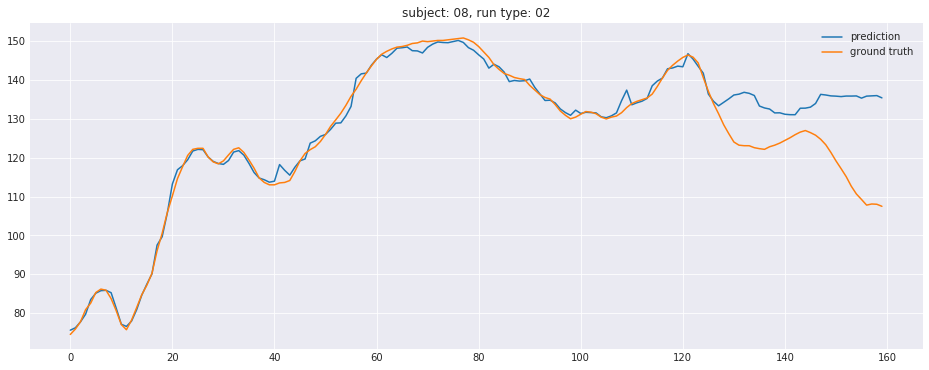

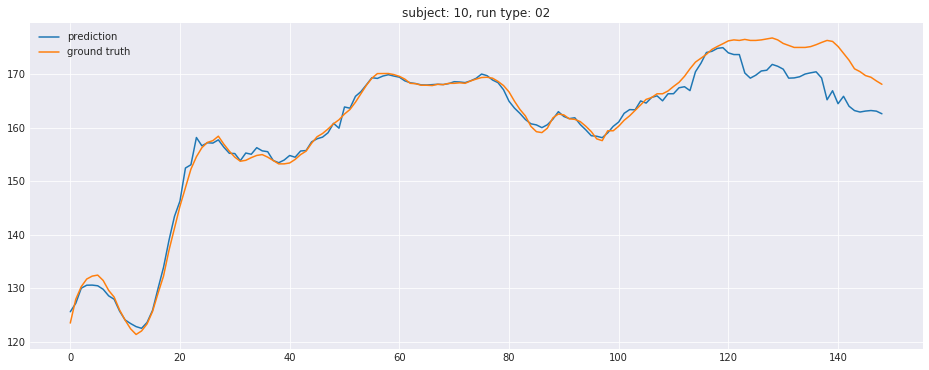

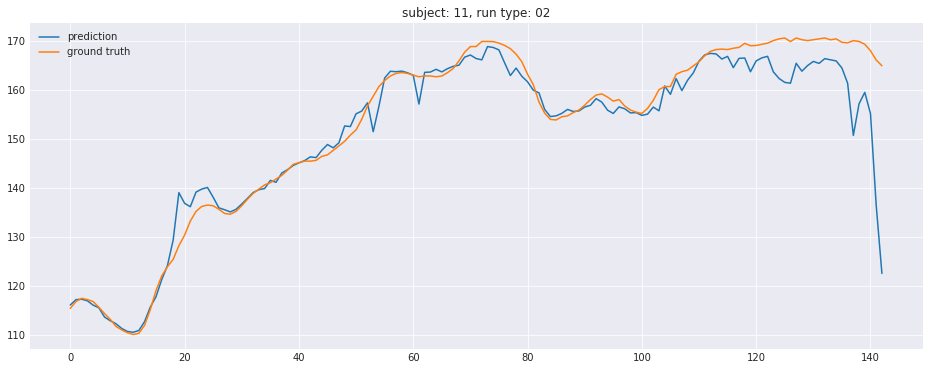

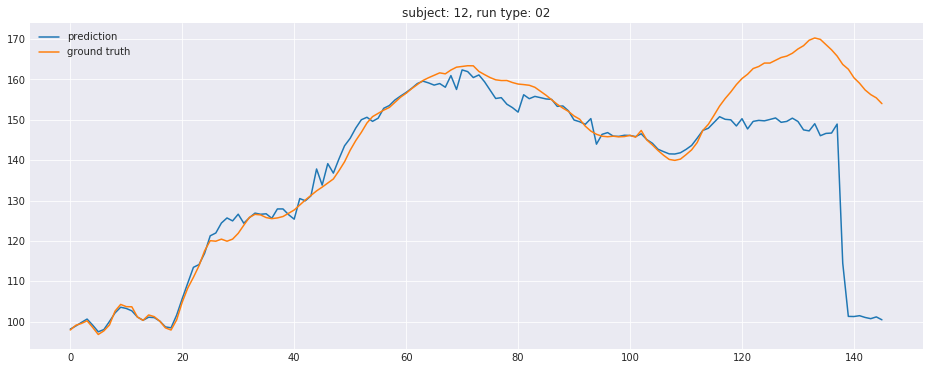

Computed error metric...


4.0982590058927846

In [33]:
Evaluate()

---

# Project Write-up

## Code Description

* `Evaluate()` retrieves the Troika dataset, calls `RunPulseRateAlgorithm()` and then returns the mean absolute error at 90% availability.
* Input needed:
    * `data_fl`: ppg and acc signal data from sensors
    * `ref_fl`: ground truth heart rates as reference data
* Library versions:
    * `numpy 1.12.1`
    * `scipy 1.2.1`
    * `re 2.2.1`
    * `matplotlib 2.1.0`
    * `seaborn 0.8.1`
    * `sklearn 0.19.1`
* Parameters:
    * `fs`: sampling rate of accelerometer (=`125`)
    * `window_length`: length of the signal (=`8`)
    * `window_shift`: shift of the signal (=`2`)
* With this input, `RunPulseRateAlgorithm()` predicts heart rate and calculates (1) confidence estimates for the 8-second time windows of ppg and acc data and (2) the error of the prediction by comparing the estimates with the ground truth.
* The resulting errors and confidences are aggregated to the MAE at 90% availability with `AggregateErrorMetric()`.

## Data Description

> For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.

– *Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link*

* The dataset contains 11 subjects aging 18 to 35
* The activities were rest, jog, and run at various speeds on a treadmill
* There were 12 sessions of data from 11 subjects, each session was 5 minutes long
* Accelerometer data and two-channel ppg data are collected via a three-axis accelerometer and a ppg sensor that measures blood in the ventricles
* One-channel ECG signals provide a ground truth for heart rates since ECG signals are more accurate than wristband-based data
* Signals were sampled at 125 Hz
* The second channel of two-channel ppg data is used as suggested
* The three channels in the acc data refer to axes x, y and z

A more complete dataset would require:
* more subjects
* enrich with demographic data
* collect different age groups
* collect different medical conditions
* magnetometer data to measure absolute orientation
* gyroscope to measure angular velocity


## Algorithm Description

* This algorithm computes BPM predictions and confidences based on ppg data
* Photoplethysmogram (ppg) sensors measure blood in ventricles based on the amount of reflected light emitted by an LED
* Reflected light decreases when heart pumps and ventricles contract (more blood present, photodetector receives smaller signal) and increases when blood returns to the heart (less blood present, bigger photodetector signal)
* By measuring this oscillating waveform, the algorithm deducts the heart rate
* The waveform peaks when there is least amount of light being absorbed, which is when fewest red blood cells are present
* The accelerometer measures linear acceleration in three channels (x, y, z).
* Preprocessing: The algorithm performs Bandpass filtering, removes low and high frequencies (noise), and acc data is aggregated into a single magnitude signal
* Featurizing: Fourier-transformed signals, select those with most power
* Rule-based approach:
    * The algorithm searches for the strongest two frequencies and finds the peaks in ppg data
    * If no peak was found, the strongest frequency is used as estimation
    * If there is only one peak, use frequency of that peak
    * Else use the nearest peak's ppg frequency as estimation
* Random Forest regression approach:
    * The RF model is trained with the selected features and target
    * Features: mean, standard deviation, amplification and argmax (strongest) are computed for ppg and acc data
    * Target: ground truth reference data
* The estimated frequency in BPM is benchmarked against our ground truth and returns an MAE error in BPM and the connfidence of this estimation
* Higher confidence means that the signal has a high signal to noise ratio, while lower confidence means that the signal has a low signal to noise ratio
* Sudden changes in heart rates will affect the algorithm negatively
* Frequency signals not coming from heart rate is a common failure mode of this algorithm, e.g. with arms and hand movement

## Algorithm Performance

* MAE (mean absolute error) between the heart rate estimations from ppg and ground truth from ECG is used to benchmark the performance of this algorithm
* The MAE at 90% availability for the given training dataset when predicting with the rule-based system was 21.3971 BPM (on test set: 21.14)
* The MAE at 90% availability for the given training dataset when predicting with the Random Forest Regression model was 4.0943 BPM (on test set:  6.9)

Common failure modes with regards to signal collection and processing with ppg sensors and accelerometer:
* Arm, hand and finger movements (influences blood flow
* Arm/wrist position (influences blood flow and volume)
* Gravity (accelerometer is affected by gravity)
* Melanin (darker skin absorbs more light and has an effect on the signal measurements)

Data processing improvements:
* we used basic filtering and processing with Savgol and Bandpass
* for more robust systems we can implement Kalman filters or even particle filters

Random Forest model improvements:
* A more complete training dataset as outlined above may further improve the algorithm.
* Predictions get worse towards the end of each subject's run data. It is worth investigating some potential causes in future work (e.g., potential overfit and bias)

-----
# Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 